In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# ==========================================
# 0. CONFIGURAZIONE
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
LR = 0.001
EPOCHS = 75
N_ITEMS = 5  
W_VALUES = [0.35, 0.55]
RATIO = 0.01

In [3]:
# --- 1. DATASET MNIST SORTING (Modificato) ---
class MNISTSortingDataset(Dataset):
    def __init__(self, mnist_dataset, length=10000):
        self.length = length
        self.n_items = N_ITEMS
        
        print("Caricamento dati in RAM...")
        data = mnist_dataset.data.float() / 255.0
        self.data = (data - 0.1307) / 0.3081
        self.data = self.data.unsqueeze(1) 
        self.targets = mnist_dataset.targets
        print("Dati pronti.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        indices = torch.randperm(len(self.data))[:self.n_items]
        images = self.data[indices]
        labels = self.targets[indices] # Questi sono i valori dei numeri (es. 3, 0, 9...)
        
        sort_indices = torch.argsort(labels)
        ranks = torch.argsort(sort_indices)
        
        target_matrix = torch.zeros((self.n_items, self.n_items))
        for i in range(self.n_items):
            target_matrix[i, ranks[i]] = 1.0
            
        # RESTITUIAMO ANCHE LE LABELS ORA
        return images, target_matrix, labels


In [4]:
class PrecomputedMNISTSortingDataset(Dataset):
    def __init__(self, images_tensor, labels_tensor, length=10000):
        self.images_tensor = images_tensor
        self.length = length
        self.n_items = N_ITEMS
        
        print(f"Pre-computing {length} targets in RAM...")
        self.indices = torch.randint(0, len(images_tensor), (length, N_ITEMS))
        self.targets = torch.zeros((length, N_ITEMS, N_ITEMS))
        
        # Salviamo anche le etichette del batch per la loss simbolica
        self.batch_labels_store = torch.zeros((length, N_ITEMS), dtype=torch.long)
        
        for i in range(length):
            idxs = self.indices[i]
            batch_labels = labels_tensor[idxs]
            self.batch_labels_store[i] = batch_labels # Store
            
            sort_indices = torch.argsort(batch_labels)
            ranks = torch.argsort(sort_indices)
            for r in range(N_ITEMS):
                self.targets[i, r, ranks[r]] = 1.0
        
        print("Pre-computation finita.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img_indices = self.indices[idx]
        images = self.images_tensor[img_indices]
        target = self.targets[idx]
        labels = self.batch_labels_store[idx] # Retrieve
        
        return images, target, labels

In [5]:
class SortingNet(nn.Module):
    def __init__(self):
        super(SortingNet, self).__init__()
        # CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5), nn.MaxPool2d(2), nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5), nn.MaxPool2d(2), nn.ReLU(),
            nn.Flatten()
        )
        self.feat_dim = 320 
        
        # MLP Reasoning
        self.mlp = nn.Sequential(
            nn.Linear(N_ITEMS * self.feat_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, N_ITEMS * N_ITEMS) 
        )
        
    def forward(self, x):
        # x shape: (Batch, 5, 1, 28, 28)
        batch_size = x.size(0)
        
        # --- OTTIMIZZAZIONE ---
        # "Schiacciamo" la dimensione 5 dentro il batch
        # Diventa: (Batch * 5, 1, 28, 28)
        # La CNN processerà 32*5 = 160 immagini in parallelo in un colpo solo!
        x_reshaped = x.view(batch_size * N_ITEMS, 1, 28, 28)
        
        features = self.cnn(x_reshaped) # Shape: (Batch * 5, 320)
        
        # Torniamo alla forma separata: (Batch, 5 * 320)
        features = features.view(batch_size, N_ITEMS * self.feat_dim)
        
        out = self.mlp(features)
        out = out.view(batch_size, N_ITEMS, N_ITEMS)
        return torch.sigmoid(out)

In [6]:
# ==========================================
# 2. LA SEMANTIC LOSS ESTESA
# ==========================================
import sympy as sp
from sympy.logic.boolalg import And, Or, Not

def semantic_loss_exactly_one(probs, epsilon=1e-6):
    """Loss strutturale: righe e colonne devono sommare a 1 (Permutation Matrix)."""
    q = 1.0 - probs
    row_prod = torch.prod(q + epsilon, dim=1, keepdim=True)
    term = probs * (row_prod / (q + epsilon))
    prob_constraint = torch.sum(term, dim=1)
    return torch.mean(-torch.log(prob_constraint + epsilon))

def semantic_loss_pairwise_ordering(matrix_probs, labels, epsilon=1e-6):
    """
    Loss Pairwise di Ordinamento (Ibrida Simbolica-Subsimbolica).
    Calcola la probabilità che, date le predizioni, la lista risultante sia ordinata.
    Vincolo: Valore(Posizione j) <= Valore(Posizione j+1)
    
    APPROCCIO: Pairwise probabilistic logic - ottimizzata per GPU
    """
    # matrix_probs: (Batch, N_items, N_ranks)
    # labels: (Batch, N_items) - I valori reali dei numeri in input
    
    loss = 0
    n_ranks = matrix_probs.shape[2]
    
    # Per ogni posizione j nella sequenza di output (da 0 a N-2)
    for j in range(n_ranks - 1):
        # Probabilità che l'input 'i' finisca al rank 'j'
        prob_at_j = matrix_probs[:, :, j]      # (Batch, N_items)
        # Probabilità che l'input 'k' finisca al rank 'j+1'
        prob_at_j_plus_1 = matrix_probs[:, :, j+1] # (Batch, N_items)
        
        # Calcoliamo la probabilità congiunta per tutte le coppie (i, k)
        # BMM (Batch Matrix Mul): (B, N, 1) x (B, 1, N) -> (B, N, N)
        # joint_prob[b, i, k] = P(item i @ j AND item k @ j+1)
        joint_prob = torch.bmm(prob_at_j.unsqueeze(2), prob_at_j_plus_1.unsqueeze(1))
        
        # Creiamo una maschera logica: 1 se label[i] <= label[k], 0 altrimenti
        # Espandiamo le labels per il broadcasting
        labels_i = labels.unsqueeze(2) # (B, N, 1)
        labels_k = labels.unsqueeze(1) # (B, 1, N)
        
        # Il vincolo è soddisfatto se il numero a sinistra è <= numero a destra
        valid_pair_mask = (labels_i <= labels_k).float()
        
        # Sommiamo le probabilità di tutte le configurazioni valide
        prob_constraint_satisfied = torch.sum(joint_prob * valid_pair_mask, dim=(1, 2))
        
        # Loss = -log(probabilità che il vincolo j, j+1 sia vero)
        loss += torch.mean(-torch.log(prob_constraint_satisfied + epsilon))
        
    return loss

# ============================================
# CACHE GLOBALE PER STRUTTURA CNF
# ============================================
_CNF_CACHE = {}

def _build_cnf_structure(n_items):
    """
    Pre-costruisce la struttura CNF simbolica (eseguita UNA SOLA VOLTA).
    Ritorna dizionario con simboli e struttura delle clausole per ogni posizione.
    """
    cache_key = f"cnf_{n_items}"
    
    if cache_key in _CNF_CACHE:
        return _CNF_CACHE[cache_key]
    
    print(f"[CNF Cache] Costruzione struttura CNF per N_ITEMS={n_items}...")
    
    n_ranks = n_items
    structure = {}
    
    # Per ogni coppia di posizioni adiacenti
    for j in range(n_ranks - 1):
        # Crea variabili simboliche SymPy STATICHE
        symbolic_vars = {}
        for i in range(n_items):
            symbolic_vars[f'P_{i}_{j}'] = sp.Symbol(f'P_{i}_{j}')
            symbolic_vars[f'P_{i}_{j+1}'] = sp.Symbol(f'P_{i}_{j+1}')
        
        # Pre-costruisce tutte le possibili clausole (indipendenti dai valori)
        # Ogni clausola è associata alla coppia (i, k) che la genera
        clause_map = {}
        for i in range(n_items):
            for k in range(n_items):
                p_i_j = symbolic_vars[f'P_{i}_{j}']
                p_k_j1 = symbolic_vars[f'P_{k}_{j+1}']
                
                # Clausola: ¬P_ij ∨ ¬P_k(j+1)
                # Questa clausola si attiva SOLO se value[i] > value[k]
                clause = Or(Not(p_i_j), Not(p_k_j1))
                clause_map[(i, k)] = clause
        
        structure[j] = {
            'vars': symbolic_vars,
            'clause_map': clause_map
        }
    
    _CNF_CACHE[cache_key] = structure
    print(f"[CNF Cache] Struttura salvata in cache.")
    return structure

def semantic_loss_ordering_cnf(probs, values, epsilon=1e-6):
    """
    Versione OTTIMIZZATA CNF con SymPy - Approccio Simbolico con Caching.
    
    La struttura logica CNF viene costruita UNA SOLA VOLTA e cachata.
    Ad ogni chiamata vengono solo:
    1. Identificate le clausole attive (basate sui valori)
    2. Valutate le probabilità sull'albero pre-costruito
    
    SPEEDUP: da O(batch × positions × items²) costruzioni a O(1) costruzioni!
    """
    batch_size = probs.shape[0]
    n_items = probs.shape[1]
    n_ranks = probs.shape[2]
    
    # === OTTIMIZZAZIONE 1: Recupera struttura dalla cache ===
    cnf_structure = _build_cnf_structure(n_items)
    
    # Convertiamo in numpy per la valutazione
    probs_np = probs.detach().cpu().numpy()
    values_np = values.detach().cpu().numpy()
    
    total_loss = 0.0
    
    # Funzione di valutazione ricorsiva (INVARIATA)
    def eval_formula_prob(formula, probs_batch, symbolic_vars):
        """Valuta ricorsivamente la probabilità di una formula."""
        if isinstance(formula, sp.Symbol):
            # Estrai i, j dal nome del simbolo P_i_j
            parts = str(formula).split('_')
            i_idx = int(parts[1])
            j_idx = int(parts[2])
            return probs_batch[i_idx, j_idx]
        
        elif isinstance(formula, Not):
            return 1.0 - eval_formula_prob(formula.args[0], probs_batch, symbolic_vars)
        
        elif isinstance(formula, And):
            # P(A ∧ B) ≈ P(A) * P(B)
            prob = 1.0
            for arg in formula.args:
                prob *= eval_formula_prob(arg, probs_batch, symbolic_vars)
            return prob
        
        elif isinstance(formula, Or):
            # P(A ∨ B) = 1 - P(¬A ∧ ¬B) ≈ 1 - (1-P(A))(1-P(B))
            prob = 1.0
            for arg in formula.args:
                prob *= (1.0 - eval_formula_prob(arg, probs_batch, symbolic_vars))
            return 1.0 - prob
        
        else:
            return 1.0
    
    # Processa ogni esempio del batch
    for b in range(batch_size):
        batch_loss = 0.0
        
        # Per ogni coppia di posizioni adiacenti
        for j in range(n_ranks - 1):
            # === OTTIMIZZAZIONE 2: Recupera struttura pre-costruita ===
            pos_structure = cnf_structure[j]
            symbolic_vars = pos_structure['vars']
            clause_map = pos_structure['clause_map']
            
            # === OTTIMIZZAZIONE 3: Filtra solo clausole ATTIVE ===
            # (quelle dove value[i] > value[k], quindi violano l'ordinamento)
            active_clauses = []
            for (i, k), clause in clause_map.items():
                if values_np[b, i] > values_np[b, k]:
                    # Questa coppia viola l'ordinamento -> clausola attiva
                    active_clauses.append(clause)
            
            # Se non ci sono clausole attive, skip (tutto ordinato correttamente)
            if len(active_clauses) == 0:
                continue
            
            # === COSTRUZIONE CNF (solo clausole attive) ===
            cnf_formula = And(*active_clauses)
            
            # === VALUTAZIONE ===
            prob_cnf_satisfied = eval_formula_prob(cnf_formula, probs_np[b], symbolic_vars)
            
            # Loss: -log(P(CNF è vera))
            batch_loss += -np.log(max(prob_cnf_satisfied, epsilon))
        
        total_loss += batch_loss
    
    # Converti il risultato in un tensore PyTorch
    return torch.tensor(total_loss / batch_size, dtype=probs.dtype, device=probs.device)


def compute_full_semantic_loss(matrix_probs, labels=None):
    """Combina i vincoli strutturali e, se presenti le labels, i vincoli di ordinamento (PAIRWISE)."""
    loss = 0
    # 1. Vincolo Strutturale (Permutation Matrix)
    for i in range(N_ITEMS):
        loss += semantic_loss_exactly_one(matrix_probs[:, i, :]) # Righe
    for j in range(N_ITEMS):
        loss += semantic_loss_exactly_one(matrix_probs[:, :, j]) # Colonne
        
    # 2. Vincolo Simbolico di Ordinamento Pairwise (Opzionale, se passiamo le labels)
    if labels is not None:
        loss += semantic_loss_pairwise_ordering(matrix_probs, labels)
        
    return loss

def compute_full_semantic_loss_cnf(matrix_probs, labels):
    """
    Combina:
    1. Exactly-One (Struttura della matrice di permutazione)
    2. Ordering CNF PURO con SymPy + CACHING OTTIMIZZATO
    """
    loss = 0.0
    
    # A. Vincoli Strutturali (Righe e Colonne)
    # Nota: exactly_one lavora su vettori 1D, quindi iteriamo
    # Righe (Ogni immagine ha una sola posizione)
    for i in range(matrix_probs.size(1)):
        loss += semantic_loss_exactly_one(matrix_probs[:, i, :])
    # Colonne (Ogni posizione ha una sola immagine)
    for j in range(matrix_probs.size(2)):
        loss += semantic_loss_exactly_one(matrix_probs[:, :, j])
        
    # B. Vincoli Logici CNF PURI (SymPy) - OTTIMIZZATO CON CACHE
    loss_order = torch.tensor(0.0, device=matrix_probs.device)
    if labels is not None:
        loss_order = semantic_loss_ordering_cnf(matrix_probs, labels)
        loss += loss_order
        
    return loss


def compute_entropy_loss(probs):
    # probs shape: (Batch, 5, 5)
    epsilon = 1e-6
    # Calcola l'entropia per ogni riga (distribuzione di probabilità sulla posizione)
    entropy = -torch.sum(probs * torch.log(probs + epsilon), dim=2)
    return entropy.mean()


In [7]:
def train_semisupervised(model, train_loader, val_loader, use_semantic_loss=True, use_entropy_min=False, use_semantic_loss_cnf=False, labeled_ratio=0.05, epochs=30, w_semantic=0.4):    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion_none = nn.BCELoss(reduction='none') 
    W_ENTROPY = 0.1
    
    print(f"\n--- Training Semi-Sup | Labels: {labeled_ratio*100}% | Semantic Loss: {use_semantic_loss} | W_SEMANTIC: {w_semantic} ---")
    
    history = {'loss': [], 'validity': [], 'accuracy': []}
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        current_w = 0.0
        if use_semantic_loss or use_semantic_loss_cnf:
            current_w = w_semantic
            
        desc = f"Epoch {epoch+1} (W={current_w})"
        progress_bar = tqdm(train_loader, desc=desc, ascii=True)
        
        # MODIFICA QUI: Unpack di 3 elementi (imgs, targets, labels)
        for i, (imgs, targets, labels) in enumerate(progress_bar):
            imgs, targets, labels = imgs.to(DEVICE), targets.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            out = model(imgs)
            
            # 1. MASCHERA SEMI-SUPERVISIONATA
            mask_labeled = (torch.rand(imgs.size(0)) < labeled_ratio).float().to(DEVICE)
            
            # 2. LOSS SUPERVISIONATA
            raw_sup = criterion_none(out, targets)
            mask_expanded = mask_labeled.view(-1, 1, 1)
            masked_sup_loss = raw_sup * mask_expanded
            
            num_labeled = mask_labeled.sum()
            sup_loss = masked_sup_loss.sum() / num_labeled if num_labeled > 0 else torch.tensor(0.0).to(DEVICE)
            
            # 3. SEMANTIC LOSS (Include ora il controllo ordinamento)
            sem_loss = torch.tensor(0.0).to(DEVICE)
            if current_w > 0 and use_semantic_loss:
                # Passiamo 'labels' per attivare anche la loss simbolica sull'ordinamento
                sem_loss = compute_full_semantic_loss(out, labels)

            elif current_w > 0 and use_semantic_loss_cnf:
                sem_loss = compute_full_semantic_loss_cnf(out, labels)

            # 3,1. ENTROPY LOSS
            ent_loss = torch.tensor(0.0).to(DEVICE)
            if use_entropy_min:
                ent_loss = compute_entropy_loss(out)

            # 4. COMBINAZIONE
            if num_labeled > 0:
                loss = ((1.0 - current_w) * sup_loss) + (current_w * sem_loss)
            else:
                loss = sem_loss 

            if use_entropy_min:
                loss = loss + (W_ENTROPY * ent_loss)
            
            if loss.requires_grad:
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            
            progress_bar.set_postfix(sup=f"{sup_loss:.3f}", sem=f"{sem_loss:.3f}", ent=f"{ent_loss:.3f}")
            
        # --- VALUTAZIONE (Invariata, ma bisogna gestire l'unpack nel loop se necessario) ---
        model.eval()
        valid_count = 0
        exact_match = 0
        total = 0
        with torch.no_grad():
            # Anche qui il loader ora restituisce 3 valori
            for x, y, _ in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)
                preds = torch.argmax(out, dim=2)
                targs = torch.argmax(y, dim=2)
                
                for b in range(x.size(0)):
                    if len(torch.unique(preds[b])) == N_ITEMS:
                        valid_count += 1
                
                matches = (preds == targs).all(dim=1)
                exact_match += matches.sum().item()
                total += x.size(0)
        
        val_validity = 100 * valid_count / total
        val_accuracy = 100 * exact_match / total
        
        history['loss'].append(total_loss / len(train_loader))
        history['validity'].append(val_validity)
        history['accuracy'].append(val_accuracy)
        
        print(f"Epoch {epoch+1} | Validity: {val_validity:.2f}% | Exact Match: {val_accuracy:.2f}%")
        
    return history

In [8]:
# --- A. Caricamento e Pre-processing in RAM (Una volta sola) ---
print("Caricamento dataset MNIST in RAM...")
# Scarichiamo i dati raw
raw_train = datasets.MNIST('./data', train=True, download=True)
raw_test = datasets.MNIST('./data', train=False, download=True)

# Convertiamo TUTTO in tensori float e normalizziamo SUBITO
# Training (60k)
X_all = raw_train.data.float() / 255.0
X_all = (X_all - 0.1307) / 0.3081
X_all = X_all.unsqueeze(1) # Shape: (60000, 1, 28, 28)
Y_all = raw_train.targets

# Test (10k)
X_test = raw_test.data.float() / 255.0
X_test = (X_test - 0.1307) / 0.3081
X_test = X_test.unsqueeze(1)
Y_test = raw_test.targets

# --- B. Split Manuale dei Tensori (80% Train / 20% Val) ---
# Non usiamo random_split sui dataset, ma splittiamo i tensori stessi
split_idx = int(0.8 * len(X_all)) # 48.000

# Slicing dei tensori (crea viste in memoria, molto efficiente)
X_train, X_val = X_all[:split_idx], X_all[split_idx:]
Y_train, Y_val = Y_all[:split_idx], Y_all[split_idx:]

print(f"Dati in RAM -> Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# --- C. Creazione Dataset Veloci ---
# Passiamo i tensori specifici a ogni dataset
# length=... definisce quante "triplette" generare per epoca. 
# Mettiamo valori alti per sfruttare i dati.
train_ds = PrecomputedMNISTSortingDataset(X_train, Y_train, length=48000)
val_ds = PrecomputedMNISTSortingDataset(X_val, Y_val, length=2000)
test_ds = PrecomputedMNISTSortingDataset(X_test, Y_test, length=10000)

# DataLoader (num_workers=0 è obbligatorio qui per evitare overhead inutile)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Setup completato. Ready to train!")

Caricamento dataset MNIST in RAM...


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.46MB/s]


Dati in RAM -> Train: 48000, Val: 12000, Test: 10000
Pre-computing 48000 targets in RAM...
Pre-computation finita.
Pre-computing 2000 targets in RAM...
Pre-computation finita.
Pre-computing 10000 targets in RAM...
Pre-computation finita.
Setup completato. Ready to train!


In [9]:
# --- ESPERIMENTO CON DIVERSI VALORI DI W_SEMANTIC ---

# Valori di W_SEMANTIC da testare
w_values = [0.35, 0.55]

# Dizionario per salvare i risultati
results = {}

# --- TRAINING CON SEMANTIC LOSS PAIRWISE OTTIMIZZATA ---
for w in W_VALUES:
    print(f"\n{'='*60}")
    print(f">>> TRAINING CON W_SEMANTIC = {w} (Pairwise Optimized)")
    print(f"{'='*60}")
    
    model = SortingNet().to(DEVICE)
    hist = train_semisupervised(model, train_loader, val_loader, 
                                use_semantic_loss=(w > 0), 
                                use_entropy_min=True,
                                use_semantic_loss_cnf=False,
                                labeled_ratio=RATIO, 
                                epochs=EPOCHS,
                                w_semantic=w)
    
    results[w] = {
        'model': model,
        'history': hist
    }

# --- TRAINING BASELINE (Senza Semantic Loss per confronto) ---
print(f"\n{'='*60}")
print(">>> TRAINING BASELINE (No Semantic Loss)")
print(f"{'='*60}")
model_base = SortingNet().to(DEVICE)
hist_base = train_semisupervised(model_base, train_loader, val_loader, 
                                 use_semantic_loss=False, 
                                 use_entropy_min=True,
                                 use_semantic_loss_cnf=False,
                                 labeled_ratio=RATIO, 
                                 epochs=EPOCHS)

# --- TRAINING CON SEMANTIC LOSS CNF PURA (Solo W=0.55) ---
print(f"\n{'='*60}")
print(">>> TRAINING CON CNF PURA (SymPy) - W_SEMANTIC = 0.55")
print(f"{'='*60}")
model_cnf = SortingNet().to(DEVICE)
hist_cnf = train_semisupervised(model_cnf, train_loader, val_loader, 
                                use_semantic_loss=False, 
                                use_entropy_min=True,
                                use_semantic_loss_cnf=True,
                                labeled_ratio=RATIO, 
                                epochs=EPOCHS,
                                w_semantic=0.55)



>>> TRAINING CON W_SEMANTIC = 0.35 (Pairwise Optimized)

--- Training Semi-Sup | Labels: 1.0% | Semantic Loss: True | W_SEMANTIC: 0.35 ---


Epoch 1 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 | Validity: 8.90% | Exact Match: 0.65%


Epoch 2 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 | Validity: 13.55% | Exact Match: 1.30%


Epoch 3 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 | Validity: 22.40% | Exact Match: 2.95%


Epoch 4 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 | Validity: 23.30% | Exact Match: 3.95%


Epoch 5 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 | Validity: 22.45% | Exact Match: 4.95%


Epoch 6 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 | Validity: 24.35% | Exact Match: 6.20%


Epoch 7 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 | Validity: 28.10% | Exact Match: 7.05%


Epoch 8 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 | Validity: 23.85% | Exact Match: 6.45%


Epoch 9 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 | Validity: 25.10% | Exact Match: 7.05%


Epoch 10 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 | Validity: 25.50% | Exact Match: 7.30%


Epoch 11 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 | Validity: 29.00% | Exact Match: 8.10%


Epoch 12 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 | Validity: 29.10% | Exact Match: 8.70%


Epoch 13 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 | Validity: 30.75% | Exact Match: 7.80%


Epoch 14 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 | Validity: 32.80% | Exact Match: 10.00%


Epoch 15 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15 | Validity: 31.25% | Exact Match: 10.95%


Epoch 16 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16 | Validity: 32.85% | Exact Match: 10.15%


Epoch 17 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17 | Validity: 32.85% | Exact Match: 10.00%


Epoch 18 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18 | Validity: 35.30% | Exact Match: 9.50%


Epoch 19 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19 | Validity: 33.35% | Exact Match: 12.65%


Epoch 20 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20 | Validity: 34.30% | Exact Match: 12.85%


Epoch 21 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21 | Validity: 37.05% | Exact Match: 11.00%


Epoch 22 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22 | Validity: 37.30% | Exact Match: 12.70%


Epoch 23 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23 | Validity: 36.75% | Exact Match: 13.70%


Epoch 24 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24 | Validity: 38.70% | Exact Match: 14.70%


Epoch 25 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25 | Validity: 36.10% | Exact Match: 13.55%


Epoch 26 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26 | Validity: 36.90% | Exact Match: 14.50%


Epoch 27 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27 | Validity: 40.60% | Exact Match: 16.20%


Epoch 28 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28 | Validity: 40.85% | Exact Match: 15.85%


Epoch 29 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29 | Validity: 40.25% | Exact Match: 15.35%


Epoch 30 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30 | Validity: 40.50% | Exact Match: 15.90%


Epoch 31 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 31 | Validity: 40.65% | Exact Match: 16.45%


Epoch 32 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 32 | Validity: 43.70% | Exact Match: 18.75%


Epoch 33 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 33 | Validity: 42.40% | Exact Match: 18.15%


Epoch 34 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 34 | Validity: 44.45% | Exact Match: 20.40%


Epoch 35 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 35 | Validity: 45.80% | Exact Match: 20.95%


Epoch 36 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 36 | Validity: 42.20% | Exact Match: 20.50%


Epoch 37 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 37 | Validity: 44.10% | Exact Match: 20.05%


Epoch 38 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 38 | Validity: 46.55% | Exact Match: 21.10%


Epoch 39 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 39 | Validity: 46.35% | Exact Match: 22.45%


Epoch 40 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 40 | Validity: 46.50% | Exact Match: 22.50%


Epoch 41 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 41 | Validity: 44.55% | Exact Match: 20.45%


Epoch 42 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 42 | Validity: 46.40% | Exact Match: 21.90%


Epoch 43 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 43 | Validity: 47.90% | Exact Match: 22.90%


Epoch 44 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 44 | Validity: 49.85% | Exact Match: 24.35%


Epoch 45 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 45 | Validity: 48.10% | Exact Match: 23.30%


Epoch 46 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 46 | Validity: 50.10% | Exact Match: 23.50%


Epoch 47 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 47 | Validity: 48.70% | Exact Match: 25.25%


Epoch 48 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 48 | Validity: 53.10% | Exact Match: 25.80%


Epoch 49 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 49 | Validity: 50.60% | Exact Match: 23.30%


Epoch 50 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 50 | Validity: 52.55% | Exact Match: 26.05%


Epoch 51 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 51 | Validity: 52.95% | Exact Match: 26.50%


Epoch 52 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 52 | Validity: 53.20% | Exact Match: 28.00%


Epoch 53 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 53 | Validity: 53.40% | Exact Match: 28.65%


Epoch 54 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 54 | Validity: 53.70% | Exact Match: 28.70%


Epoch 55 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 55 | Validity: 54.30% | Exact Match: 29.15%


Epoch 56 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 56 | Validity: 54.50% | Exact Match: 28.95%


Epoch 57 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 57 | Validity: 53.95% | Exact Match: 29.00%


Epoch 58 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 58 | Validity: 50.75% | Exact Match: 26.95%


Epoch 59 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 59 | Validity: 55.20% | Exact Match: 29.70%


Epoch 60 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 60 | Validity: 55.60% | Exact Match: 30.70%


Epoch 61 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 61 | Validity: 56.10% | Exact Match: 32.50%


Epoch 62 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 62 | Validity: 57.05% | Exact Match: 32.70%


Epoch 63 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 63 | Validity: 56.20% | Exact Match: 30.65%


Epoch 64 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 64 | Validity: 56.45% | Exact Match: 32.55%


Epoch 65 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 65 | Validity: 59.40% | Exact Match: 34.00%


Epoch 66 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 66 | Validity: 57.70% | Exact Match: 33.35%


Epoch 67 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 67 | Validity: 59.05% | Exact Match: 34.60%


Epoch 68 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 68 | Validity: 60.50% | Exact Match: 35.25%


Epoch 69 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 69 | Validity: 56.75% | Exact Match: 33.15%


Epoch 70 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 70 | Validity: 60.05% | Exact Match: 34.95%


Epoch 71 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 71 | Validity: 60.05% | Exact Match: 35.35%


Epoch 72 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 72 | Validity: 60.90% | Exact Match: 35.35%


Epoch 73 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 73 | Validity: 59.30% | Exact Match: 34.65%


Epoch 74 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 74 | Validity: 60.05% | Exact Match: 35.90%


Epoch 75 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 75 | Validity: 59.40% | Exact Match: 34.60%

>>> TRAINING CON W_SEMANTIC = 0.55 (Pairwise Optimized)

--- Training Semi-Sup | Labels: 1.0% | Semantic Loss: True | W_SEMANTIC: 0.55 ---


Epoch 1 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 | Validity: 20.45% | Exact Match: 1.50%


Epoch 2 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 | Validity: 21.85% | Exact Match: 2.05%


Epoch 3 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 | Validity: 23.40% | Exact Match: 3.75%


Epoch 4 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 | Validity: 27.20% | Exact Match: 4.10%


Epoch 5 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 | Validity: 25.70% | Exact Match: 4.90%


Epoch 6 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 | Validity: 30.55% | Exact Match: 5.25%


Epoch 7 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 | Validity: 29.55% | Exact Match: 6.60%


Epoch 8 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 | Validity: 28.70% | Exact Match: 7.60%


Epoch 9 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 | Validity: 29.45% | Exact Match: 8.25%


Epoch 10 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 | Validity: 34.00% | Exact Match: 10.05%


Epoch 11 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 | Validity: 34.25% | Exact Match: 8.00%


Epoch 12 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 | Validity: 34.70% | Exact Match: 10.05%


Epoch 13 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 | Validity: 40.75% | Exact Match: 10.70%


Epoch 14 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 | Validity: 37.20% | Exact Match: 12.05%


Epoch 15 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15 | Validity: 39.35% | Exact Match: 14.15%


Epoch 16 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16 | Validity: 39.00% | Exact Match: 13.50%


Epoch 17 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17 | Validity: 40.75% | Exact Match: 14.60%


Epoch 18 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18 | Validity: 41.35% | Exact Match: 14.25%


Epoch 19 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19 | Validity: 42.40% | Exact Match: 14.10%


Epoch 20 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20 | Validity: 44.50% | Exact Match: 15.70%


Epoch 21 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21 | Validity: 46.85% | Exact Match: 16.35%


Epoch 22 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22 | Validity: 43.95% | Exact Match: 16.30%


Epoch 23 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23 | Validity: 46.05% | Exact Match: 17.15%


Epoch 24 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24 | Validity: 44.90% | Exact Match: 17.00%


Epoch 25 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25 | Validity: 47.50% | Exact Match: 19.90%


Epoch 26 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26 | Validity: 45.75% | Exact Match: 17.90%


Epoch 27 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27 | Validity: 50.10% | Exact Match: 20.30%


Epoch 28 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28 | Validity: 49.25% | Exact Match: 20.60%


Epoch 29 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29 | Validity: 51.05% | Exact Match: 21.85%


Epoch 30 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30 | Validity: 50.40% | Exact Match: 21.20%


Epoch 31 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 31 | Validity: 53.40% | Exact Match: 23.75%


Epoch 32 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 32 | Validity: 53.15% | Exact Match: 24.30%


Epoch 33 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 33 | Validity: 54.85% | Exact Match: 25.05%


Epoch 34 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 34 | Validity: 54.25% | Exact Match: 25.80%


Epoch 35 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 35 | Validity: 53.60% | Exact Match: 24.70%


Epoch 36 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 36 | Validity: 54.15% | Exact Match: 25.30%


Epoch 37 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 37 | Validity: 56.90% | Exact Match: 25.90%


Epoch 38 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 38 | Validity: 56.15% | Exact Match: 26.25%


Epoch 39 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 39 | Validity: 60.45% | Exact Match: 28.25%


Epoch 40 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 40 | Validity: 56.05% | Exact Match: 27.35%


Epoch 41 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 41 | Validity: 62.10% | Exact Match: 30.40%


Epoch 42 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 42 | Validity: 57.80% | Exact Match: 29.90%


Epoch 43 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 43 | Validity: 59.25% | Exact Match: 31.30%


Epoch 44 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 44 | Validity: 60.35% | Exact Match: 30.20%


Epoch 45 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 45 | Validity: 62.90% | Exact Match: 33.00%


Epoch 46 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 46 | Validity: 64.60% | Exact Match: 32.55%


Epoch 47 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 47 | Validity: 61.45% | Exact Match: 31.00%


Epoch 48 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 48 | Validity: 61.20% | Exact Match: 30.55%


Epoch 49 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 49 | Validity: 63.30% | Exact Match: 33.60%


Epoch 50 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 50 | Validity: 65.70% | Exact Match: 35.30%


Epoch 51 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 51 | Validity: 66.35% | Exact Match: 35.90%


Epoch 52 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 52 | Validity: 65.20% | Exact Match: 35.50%


Epoch 53 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 53 | Validity: 64.45% | Exact Match: 33.95%


Epoch 54 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 54 | Validity: 66.65% | Exact Match: 34.10%


Epoch 55 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 55 | Validity: 64.35% | Exact Match: 34.30%


Epoch 56 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 56 | Validity: 65.60% | Exact Match: 35.80%


Epoch 57 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 57 | Validity: 66.05% | Exact Match: 37.50%


Epoch 58 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 58 | Validity: 67.40% | Exact Match: 37.45%


Epoch 59 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 59 | Validity: 66.30% | Exact Match: 35.85%


Epoch 60 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 60 | Validity: 68.05% | Exact Match: 37.15%


Epoch 61 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 61 | Validity: 67.65% | Exact Match: 39.45%


Epoch 62 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 62 | Validity: 65.50% | Exact Match: 39.60%


Epoch 63 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 63 | Validity: 66.55% | Exact Match: 38.40%


Epoch 64 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 64 | Validity: 67.45% | Exact Match: 40.35%


Epoch 65 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 65 | Validity: 66.40% | Exact Match: 38.20%


Epoch 66 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 66 | Validity: 67.65% | Exact Match: 40.50%


Epoch 67 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 67 | Validity: 68.05% | Exact Match: 41.30%


Epoch 68 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 68 | Validity: 70.35% | Exact Match: 41.05%


Epoch 69 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 69 | Validity: 68.15% | Exact Match: 39.85%


Epoch 70 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 70 | Validity: 69.05% | Exact Match: 40.80%


Epoch 71 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 71 | Validity: 68.80% | Exact Match: 40.75%


Epoch 72 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 72 | Validity: 70.35% | Exact Match: 41.35%


Epoch 73 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 73 | Validity: 71.00% | Exact Match: 42.00%


Epoch 74 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 74 | Validity: 70.80% | Exact Match: 41.70%


Epoch 75 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 75 | Validity: 68.90% | Exact Match: 41.60%

>>> TRAINING BASELINE (No Semantic Loss)

--- Training Semi-Sup | Labels: 1.0% | Semantic Loss: False | W_SEMANTIC: 0.4 ---


Epoch 1 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 | Validity: 9.40% | Exact Match: 0.50%


Epoch 2 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 | Validity: 12.35% | Exact Match: 1.10%


Epoch 3 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 | Validity: 11.25% | Exact Match: 1.75%


Epoch 4 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 | Validity: 13.30% | Exact Match: 1.60%


Epoch 5 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 | Validity: 19.65% | Exact Match: 3.40%


Epoch 6 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 | Validity: 20.25% | Exact Match: 4.55%


Epoch 7 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 | Validity: 20.70% | Exact Match: 4.90%


Epoch 8 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 | Validity: 18.75% | Exact Match: 5.25%


Epoch 9 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 | Validity: 20.95% | Exact Match: 5.25%


Epoch 10 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 | Validity: 24.75% | Exact Match: 6.75%


Epoch 11 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 | Validity: 22.75% | Exact Match: 6.15%


Epoch 12 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 | Validity: 22.15% | Exact Match: 6.75%


Epoch 13 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 | Validity: 24.45% | Exact Match: 7.45%


Epoch 14 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 | Validity: 25.15% | Exact Match: 6.90%


Epoch 15 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15 | Validity: 26.60% | Exact Match: 7.85%


Epoch 16 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16 | Validity: 25.85% | Exact Match: 8.85%


Epoch 17 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17 | Validity: 29.75% | Exact Match: 9.85%


Epoch 18 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18 | Validity: 27.40% | Exact Match: 9.50%


Epoch 19 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19 | Validity: 29.45% | Exact Match: 8.60%


Epoch 20 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20 | Validity: 31.90% | Exact Match: 10.25%


Epoch 21 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21 | Validity: 30.30% | Exact Match: 9.20%


Epoch 22 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22 | Validity: 27.90% | Exact Match: 10.20%


Epoch 23 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23 | Validity: 32.05% | Exact Match: 10.10%


Epoch 24 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24 | Validity: 34.10% | Exact Match: 12.30%


Epoch 25 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25 | Validity: 32.00% | Exact Match: 12.40%


Epoch 26 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26 | Validity: 34.15% | Exact Match: 12.15%


Epoch 27 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27 | Validity: 32.35% | Exact Match: 12.10%


Epoch 28 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28 | Validity: 32.60% | Exact Match: 12.55%


Epoch 29 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29 | Validity: 35.50% | Exact Match: 15.35%


Epoch 30 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30 | Validity: 35.95% | Exact Match: 14.30%


Epoch 31 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 31 | Validity: 34.40% | Exact Match: 15.30%


Epoch 32 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 32 | Validity: 35.95% | Exact Match: 13.10%


Epoch 33 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 33 | Validity: 37.45% | Exact Match: 14.20%


Epoch 34 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 34 | Validity: 36.85% | Exact Match: 15.05%


Epoch 35 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 35 | Validity: 37.00% | Exact Match: 14.30%


Epoch 36 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 36 | Validity: 37.05% | Exact Match: 14.30%


Epoch 37 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 37 | Validity: 38.25% | Exact Match: 15.90%


Epoch 38 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 38 | Validity: 37.75% | Exact Match: 16.35%


Epoch 39 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 39 | Validity: 39.00% | Exact Match: 16.90%


Epoch 40 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 40 | Validity: 37.50% | Exact Match: 14.80%


Epoch 41 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 41 | Validity: 35.30% | Exact Match: 15.65%


Epoch 42 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 42 | Validity: 39.10% | Exact Match: 18.35%


Epoch 43 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 43 | Validity: 41.75% | Exact Match: 18.15%


Epoch 44 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 44 | Validity: 40.45% | Exact Match: 17.40%


Epoch 45 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 45 | Validity: 41.10% | Exact Match: 19.05%


Epoch 46 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 46 | Validity: 43.30% | Exact Match: 19.15%


Epoch 47 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 47 | Validity: 42.50% | Exact Match: 20.05%


Epoch 48 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 48 | Validity: 43.10% | Exact Match: 20.35%


Epoch 49 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 49 | Validity: 40.75% | Exact Match: 18.45%


Epoch 50 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 50 | Validity: 41.45% | Exact Match: 19.35%


Epoch 51 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 51 | Validity: 42.00% | Exact Match: 20.15%


Epoch 52 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 52 | Validity: 42.65% | Exact Match: 21.00%


Epoch 53 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 53 | Validity: 44.20% | Exact Match: 20.55%


Epoch 54 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 54 | Validity: 44.25% | Exact Match: 20.55%


Epoch 55 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 55 | Validity: 44.20% | Exact Match: 21.75%


Epoch 56 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 56 | Validity: 42.75% | Exact Match: 21.50%


Epoch 57 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 57 | Validity: 45.30% | Exact Match: 21.80%


Epoch 58 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 58 | Validity: 42.85% | Exact Match: 21.05%


Epoch 59 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 59 | Validity: 46.60% | Exact Match: 22.50%


Epoch 60 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 60 | Validity: 46.20% | Exact Match: 22.40%


Epoch 61 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 61 | Validity: 44.95% | Exact Match: 23.00%


Epoch 62 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 62 | Validity: 44.85% | Exact Match: 21.95%


Epoch 63 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 63 | Validity: 46.55% | Exact Match: 22.55%


Epoch 64 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 64 | Validity: 45.40% | Exact Match: 22.45%


Epoch 65 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 65 | Validity: 46.90% | Exact Match: 23.20%


Epoch 66 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 66 | Validity: 45.40% | Exact Match: 23.00%


Epoch 67 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 67 | Validity: 48.65% | Exact Match: 25.55%


Epoch 68 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 68 | Validity: 49.40% | Exact Match: 24.65%


Epoch 69 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 69 | Validity: 47.80% | Exact Match: 26.15%


Epoch 70 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 70 | Validity: 49.60% | Exact Match: 25.20%


Epoch 71 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 71 | Validity: 48.85% | Exact Match: 26.15%


Epoch 72 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 72 | Validity: 49.25% | Exact Match: 27.65%


Epoch 73 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 73 | Validity: 48.20% | Exact Match: 27.50%


Epoch 74 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 74 | Validity: 47.85% | Exact Match: 24.80%


Epoch 75 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 75 | Validity: 48.05% | Exact Match: 26.60%

>>> TRAINING CON CNF PURA (SymPy) - W_SEMANTIC = 0.55

--- Training Semi-Sup | Labels: 1.0% | Semantic Loss: False | W_SEMANTIC: 0.55 ---


Epoch 1 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

[CNF Cache] Costruzione struttura CNF per N_ITEMS=5...
[CNF Cache] Struttura salvata in cache.
Epoch 1 | Validity: 8.35% | Exact Match: 0.45%


Epoch 2 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 | Validity: 14.15% | Exact Match: 1.80%


Epoch 3 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 | Validity: 18.30% | Exact Match: 2.00%


Epoch 4 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 | Validity: 33.20% | Exact Match: 3.60%


Epoch 5 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 | Validity: 28.25% | Exact Match: 4.25%


Epoch 6 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 | Validity: 30.85% | Exact Match: 4.25%


Epoch 7 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 | Validity: 29.60% | Exact Match: 4.95%


Epoch 8 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 | Validity: 35.60% | Exact Match: 6.30%


Epoch 9 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 | Validity: 33.45% | Exact Match: 5.90%


Epoch 10 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 | Validity: 36.60% | Exact Match: 3.15%


Epoch 11 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 | Validity: 33.50% | Exact Match: 7.15%


Epoch 12 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 | Validity: 33.30% | Exact Match: 6.00%


Epoch 13 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 | Validity: 30.85% | Exact Match: 6.65%


Epoch 14 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 | Validity: 29.85% | Exact Match: 7.15%


Epoch 15 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15 | Validity: 32.00% | Exact Match: 7.80%


Epoch 16 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16 | Validity: 32.05% | Exact Match: 7.70%


Epoch 17 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17 | Validity: 30.10% | Exact Match: 7.80%


Epoch 18 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18 | Validity: 34.65% | Exact Match: 8.70%


Epoch 19 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19 | Validity: 31.25% | Exact Match: 7.70%


Epoch 20 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20 | Validity: 33.40% | Exact Match: 10.90%


Epoch 21 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21 | Validity: 34.95% | Exact Match: 10.25%


Epoch 22 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22 | Validity: 24.05% | Exact Match: 8.45%


Epoch 23 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23 | Validity: 38.50% | Exact Match: 10.65%


Epoch 24 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24 | Validity: 35.30% | Exact Match: 10.35%


Epoch 25 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25 | Validity: 36.55% | Exact Match: 11.25%


Epoch 26 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26 | Validity: 37.15% | Exact Match: 11.70%


Epoch 27 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27 | Validity: 37.20% | Exact Match: 11.65%


Epoch 28 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28 | Validity: 37.20% | Exact Match: 12.30%


Epoch 29 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29 | Validity: 36.00% | Exact Match: 11.80%


Epoch 30 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30 | Validity: 40.20% | Exact Match: 14.30%


Epoch 31 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 31 | Validity: 43.20% | Exact Match: 14.70%


Epoch 32 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 32 | Validity: 40.05% | Exact Match: 14.05%


Epoch 33 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 33 | Validity: 37.90% | Exact Match: 14.00%


Epoch 34 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 34 | Validity: 39.20% | Exact Match: 14.50%


Epoch 35 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 35 | Validity: 42.50% | Exact Match: 15.85%


Epoch 36 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 36 | Validity: 41.25% | Exact Match: 14.65%


Epoch 37 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 37 | Validity: 40.60% | Exact Match: 14.70%


Epoch 38 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 38 | Validity: 38.85% | Exact Match: 14.70%


Epoch 39 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 39 | Validity: 42.90% | Exact Match: 14.65%


Epoch 40 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 40 | Validity: 45.85% | Exact Match: 16.20%


Epoch 41 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 41 | Validity: 46.20% | Exact Match: 16.75%


Epoch 42 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 42 | Validity: 43.95% | Exact Match: 14.65%


Epoch 43 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 43 | Validity: 44.90% | Exact Match: 17.10%


Epoch 44 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 44 | Validity: 46.15% | Exact Match: 18.00%


Epoch 45 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 45 | Validity: 47.60% | Exact Match: 19.25%


Epoch 46 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 46 | Validity: 49.65% | Exact Match: 19.25%


Epoch 47 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 47 | Validity: 49.45% | Exact Match: 18.25%


Epoch 48 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 48 | Validity: 49.40% | Exact Match: 18.65%


Epoch 49 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 49 | Validity: 48.80% | Exact Match: 21.10%


Epoch 50 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 50 | Validity: 47.75% | Exact Match: 18.90%


Epoch 51 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 51 | Validity: 49.25% | Exact Match: 20.85%


Epoch 52 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 52 | Validity: 51.80% | Exact Match: 20.85%


Epoch 53 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 53 | Validity: 51.20% | Exact Match: 21.75%


Epoch 54 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 54 | Validity: 51.20% | Exact Match: 23.30%


Epoch 55 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 55 | Validity: 51.80% | Exact Match: 20.85%


Epoch 56 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 56 | Validity: 54.05% | Exact Match: 23.90%


Epoch 57 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 57 | Validity: 53.10% | Exact Match: 22.25%


Epoch 58 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 58 | Validity: 52.45% | Exact Match: 23.70%


Epoch 59 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 59 | Validity: 52.00% | Exact Match: 21.40%


Epoch 60 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 60 | Validity: 53.20% | Exact Match: 23.55%


Epoch 61 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 61 | Validity: 54.10% | Exact Match: 23.10%


Epoch 62 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 62 | Validity: 54.20% | Exact Match: 24.60%


Epoch 63 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 63 | Validity: 53.25% | Exact Match: 24.50%


Epoch 64 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 64 | Validity: 53.70% | Exact Match: 25.20%


Epoch 65 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 65 | Validity: 51.90% | Exact Match: 22.90%


Epoch 66 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 66 | Validity: 52.45% | Exact Match: 25.75%


Epoch 67 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 67 | Validity: 55.80% | Exact Match: 26.15%


Epoch 68 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 68 | Validity: 54.55% | Exact Match: 24.05%


Epoch 69 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 69 | Validity: 55.35% | Exact Match: 26.40%


Epoch 70 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 70 | Validity: 56.20% | Exact Match: 26.05%


Epoch 71 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 71 | Validity: 55.50% | Exact Match: 26.55%


Epoch 72 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 72 | Validity: 56.90% | Exact Match: 26.50%


Epoch 73 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 73 | Validity: 58.25% | Exact Match: 26.30%


Epoch 74 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 74 | Validity: 56.40% | Exact Match: 25.00%


Epoch 75 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 75 | Validity: 56.80% | Exact Match: 26.50%


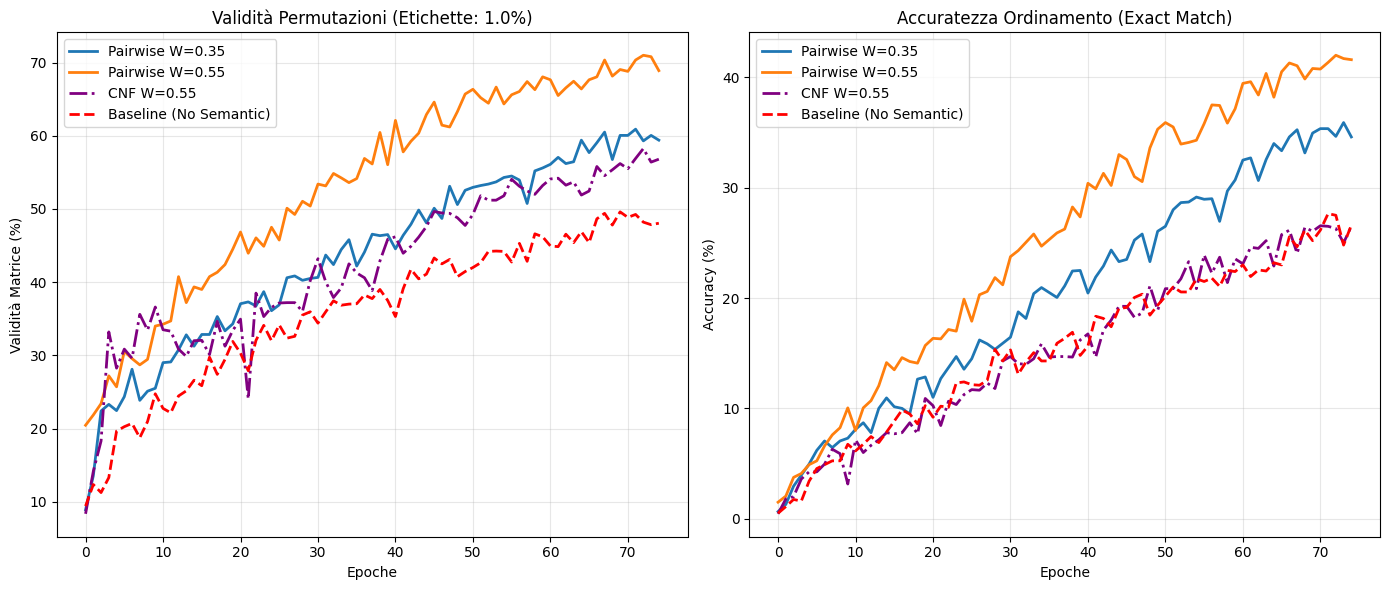


RIEPILOGO RISULTATI FINALI:
Pairwise W=0.35 -> Validity: 59.40% | Accuracy: 34.60%
------------------------------------------------------------
Pairwise W=0.55 -> Validity: 68.90% | Accuracy: 41.60%
------------------------------------------------------------
CNF W=0.55       -> Validity: 56.80% | Accuracy: 26.50%
------------------------------------------------------------
Baseline         -> Validity: 48.05% | Accuracy: 26.60%


In [10]:
# --- GRAFICI COMPARATIVI ---
plt.figure(figsize=(14, 6))

# Grafico Validità
plt.subplot(1, 2, 1)
for w in W_VALUES:
    plt.plot(results[w]['history']['validity'], label=f'Pairwise W={w}', linewidth=2)
plt.plot(hist_cnf['validity'], label='CNF W=0.55', linewidth=2, linestyle='-.', color='purple')
plt.plot(hist_base['validity'], label='Baseline (No Semantic)', color='red', linestyle='--', linewidth=2)
plt.title(f"Validità Permutazioni (Etichette: {RATIO*100}%)")
plt.xlabel("Epoche")
plt.ylabel("Validità Matrice (%)")
plt.legend()
plt.grid(alpha=0.3)

# Grafico Accuracy
plt.subplot(1, 2, 2)
for w in W_VALUES:
    plt.plot(results[w]['history']['accuracy'], label=f'Pairwise W={w}', linewidth=2)
plt.plot(hist_cnf['accuracy'], label='CNF W=0.55', linewidth=2, linestyle='-.', color='purple')
plt.plot(hist_base['accuracy'], label='Baseline (No Semantic)', color='red', linestyle='--', linewidth=2)
plt.title(f"Accuratezza Ordinamento (Exact Match)")
plt.xlabel("Epoche")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- STAMPA RISULTATI FINALI ---
print("\n" + "="*60)
print("RIEPILOGO RISULTATI FINALI:")
print("="*60)
for w in W_VALUES:
    final_validity = results[w]['history']['validity'][-1]
    final_accuracy = results[w]['history']['accuracy'][-1]
    print(f"Pairwise W={w:4.2f} -> Validity: {final_validity:5.2f}% | Accuracy: {final_accuracy:5.2f}%")
    print("-"*60)

final_validity_cnf = hist_cnf['validity'][-1]
final_accuracy_cnf = hist_cnf['accuracy'][-1]
print(f"CNF W=0.55       -> Validity: {final_validity_cnf:5.2f}% | Accuracy: {final_accuracy_cnf:5.2f}%")
print("-"*60)

final_validity_base = hist_base['validity'][-1]
final_accuracy_base = hist_base['accuracy'][-1]
print(f"Baseline         -> Validity: {final_validity_base:5.2f}% | Accuracy: {final_accuracy_base:5.2f}%")


In [11]:
def final_test_metrics(model, test_loader):
    model.eval()
    
    total_samples = 0
    total_elements = 0
    
    # Contatori per le 3 metriche
    correct_sorts = 0      # Coherent
    valid_constraints = 0  # Constraint
    correct_elements = 0   # Incoherent
    
    print("--- Avvio Fase di Testing Finale ---")
    
    with torch.no_grad():
        # MODIFICA QUI: Aggiunto ', _' per intercettare le labels e ignorarle
        for images, targets, _ in test_loader: 
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)
            
            # Forward pass
            outputs = model(images)
            
            # --- Calcoli ---
            # 1. Convertiamo le probabilità in indici (0-4)
            preds = torch.argmax(outputs, dim=2)      # Shape: (Batch, 5)
            true_labels = torch.argmax(targets, dim=2) # Shape: (Batch, 5)
            
            batch_size = images.size(0)
            total_samples += batch_size
            total_elements += (batch_size * 5) # 5 elementi per ogni esempio
            
            # METRICA A: Coherent Accuracy (Tutto l'ordinamento è giusto?)
            rows_match = (preds == true_labels).all(dim=1)
            correct_sorts += rows_match.sum().item()
            
            # METRICA B: Incoherent Accuracy (Quanti singoli numeri sono al posto giusto?)
            correct_elements += (preds == true_labels).sum().item()
            
            # METRICA C: Constraint Accuracy (È una permutazione valida?)
            for i in range(batch_size):
                pred_row = preds[i]
                unique_values = torch.unique(pred_row)
                if len(unique_values) == 5: # Assumendo N_ITEMS = 5
                    valid_constraints += 1

    # --- Risultati Finali ---
    coherent_acc = 100.0 * correct_sorts / total_samples
    incoherent_acc = 100.0 * correct_elements / total_elements
    constraint_acc = 100.0 * valid_constraints / total_samples
    
    print(f"\nRISULTATI DEL TEST SU {total_samples} ESEMPI:")
    print(f"1. Coherent Accuracy (Ordinamento Perfetto):  {coherent_acc:.2f}%")
    print(f"   -> (Metriche Paper: 'Coherent')")
    print(f"2. Incoherent Accuracy (Elementi Corretti):   {incoherent_acc:.2f}%")
    print(f"   -> (Metriche Paper: 'Incoherent')")
    print(f"3. Constraint Accuracy (Matrici Valide):      {constraint_acc:.2f}%")
    print(f"   -> (Metriche Paper: 'Constraint')")
    
    return coherent_acc, incoherent_acc, constraint_acc

# ESECUZIONE TEST SU TUTTI I MODELLI
print("\n" + "="*60)
print("TEST FINALE SU TEST SET")
print("="*60)

test_results = {}

for w in W_VALUES:
    print(f"\n>>> Testing Pairwise model with W_SEMANTIC = {w}")
    coherent, incoherent, constraint = final_test_metrics(results[w]['model'], test_loader)
    test_results[w] = {
        'coherent': coherent,
        'incoherent': incoherent,
        'constraint': constraint
    }

print(f"\n>>> Testing CNF Pure model (W_SEMANTIC = 0.55)")
coherent_cnf, incoherent_cnf, constraint_cnf = final_test_metrics(model_cnf, test_loader)

print(f"\n>>> Testing Baseline model (No Semantic Loss)")
coherent_base, incoherent_base, constraint_base = final_test_metrics(model_base, test_loader)

# --- TABELLA RIEPILOGATIVA ---
print("\n" + "="*60)
print("TABELLA COMPARATIVA RISULTATI TEST:")
print("="*60)
print(f"{'Model':<25} {'Coherent':<12} {'Incoherent':<12} {'Constraint':<12}")
print("-"*60)
for w in W_VALUES:
    print(f"Pairwise W={w:<7.2f}       {test_results[w]['coherent']:>6.2f}%      {test_results[w]['incoherent']:>6.2f}%      {test_results[w]['constraint']:>6.2f}%")
print(f"CNF W=0.55                {coherent_cnf:>6.2f}%      {incoherent_cnf:>6.2f}%      {constraint_cnf:>6.2f}%")
print(f"{'Baseline':<25} {coherent_base:>6.2f}%      {incoherent_base:>6.2f}%      {constraint_base:>6.2f}%")

# --- CALCOLO MIGLIORAMENTO (BEST vs BASELINE) ---

# 1. Trova automaticamente il miglior W basandosi sulla metrica più difficile (Coherent)
best_w = max(test_results, key=lambda k: test_results[k]['coherent'])
best_metrics = test_results[best_w]

# 2. Calcola i Delta (Differenza aritmetica in punti percentuali)
delta_coherent = best_metrics['coherent'] - coherent_base
delta_incoherent = best_metrics['incoherent'] - incoherent_base
delta_constraint = best_metrics['constraint'] - constraint_base

# 3. Delta per CNF
delta_coherent_cnf = coherent_cnf - coherent_base
delta_incoherent_cnf = incoherent_cnf - incoherent_base
delta_constraint_cnf = constraint_cnf - constraint_base

# 4. Stampa il Report di Miglioramento
print("\n" + "="*60)
print(f"CONFRONTO DIRETTO: MIGLIOR PAIRWISE (W={best_w}) vs BASELINE")
print("="*60)
print(f"{'Metric':<15} {'Best (W=' + str(best_w) + ')':<15} {'Baseline':<12} {'Gain':<12}")
print("-"*60)

# Usa :>+6.2f per forzare il segno + se il numero è positivo
print(f"{'Coherent':<15} {best_metrics['coherent']:>6.2f}%        {coherent_base:>6.2f}%      {delta_coherent:>+6.2f}%")
print(f"{'Incoherent':<15} {best_metrics['incoherent']:>6.2f}%        {incoherent_base:>6.2f}%      {delta_incoherent:>+6.2f}%")
print(f"{'Constraint':<15} {best_metrics['constraint']:>6.2f}%        {constraint_base:>6.2f}%      {delta_constraint:>+6.2f}%")
print("="*60)

print("\n" + "="*60)
print(f"CONFRONTO DIRETTO: CNF PURA (W=0.55) vs BASELINE")
print("="*60)
print(f"{'Metric':<15} {'CNF (W=0.55)':<15} {'Baseline':<12} {'Gain':<12}")
print("-"*60)
print(f"{'Coherent':<15} {coherent_cnf:>6.2f}%        {coherent_base:>6.2f}%      {delta_coherent_cnf:>+6.2f}%")
print(f"{'Incoherent':<15} {incoherent_cnf:>6.2f}%        {incoherent_base:>6.2f}%      {delta_incoherent_cnf:>+6.2f}%")
print(f"{'Constraint':<15} {constraint_cnf:>6.2f}%        {constraint_base:>6.2f}%      {delta_constraint_cnf:>+6.2f}%")
print("="*60)



TEST FINALE SU TEST SET

>>> Testing Pairwise model with W_SEMANTIC = 0.35
--- Avvio Fase di Testing Finale ---

RISULTATI DEL TEST SU 10000 ESEMPI:
1. Coherent Accuracy (Ordinamento Perfetto):  33.85%
   -> (Metriche Paper: 'Coherent')
2. Incoherent Accuracy (Elementi Corretti):   72.86%
   -> (Metriche Paper: 'Incoherent')
3. Constraint Accuracy (Matrici Valide):      59.54%
   -> (Metriche Paper: 'Constraint')

>>> Testing Pairwise model with W_SEMANTIC = 0.55
--- Avvio Fase di Testing Finale ---

RISULTATI DEL TEST SU 10000 ESEMPI:
1. Coherent Accuracy (Ordinamento Perfetto):  40.49%
   -> (Metriche Paper: 'Coherent')
2. Incoherent Accuracy (Elementi Corretti):   75.41%
   -> (Metriche Paper: 'Incoherent')
3. Constraint Accuracy (Matrici Valide):      68.89%
   -> (Metriche Paper: 'Constraint')

>>> Testing CNF Pure model (W_SEMANTIC = 0.55)
--- Avvio Fase di Testing Finale ---

RISULTATI DEL TEST SU 10000 ESEMPI:
1. Coherent Accuracy (Ordinamento Perfetto):  27.22%
   -> (Metrich

Grafico salvato come 'speedup_analysis_avg.png'.
Average Speedup calculated across all thresholds: 20.06 epochs


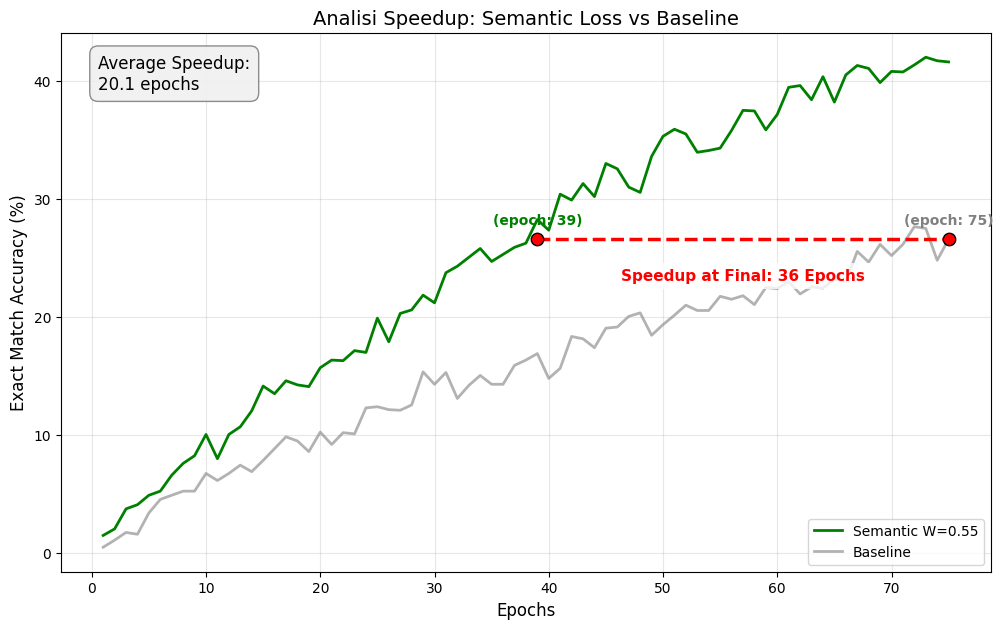

In [12]:
# ============================================================
# ANALISI DELLA VELOCITÀ DI CONVERGENZA (SPEEDUP VISUALIZZATO + MEDIA)
# ============================================================

# 1. Recupero dati
acc_semantic = results[0.55]['history']['accuracy']
acc_baseline = hist_base['accuracy']

# Creiamo asse x (epoche)
epochs_sem = range(1, len(acc_semantic) + 1)
epochs_base = range(1, len(acc_baseline) + 1)

# --- CALCOLO DELLO SPEEDUP MEDIO ---
# Calcoliamo la distanza tra le curve per ogni livello di accuracy (dal 10% al max comune)
epoch_gaps = []
max_common_acc = min(max(acc_semantic), max(acc_baseline))

# Funzione helper
def get_epoch_at_acc(acc_list, threshold):
    for ep, val in enumerate(acc_list):
        if val >= threshold:
            return ep + 1
    return None

# Campioniamo ogni 1% di accuracy
for t in range(10, int(max_common_acc)):
    e_sem = get_epoch_at_acc(acc_semantic, t)
    e_base = get_epoch_at_acc(acc_baseline, t)
    if e_sem and e_base:
        epoch_gaps.append(e_base - e_sem)

avg_speedup = np.mean(epoch_gaps) if epoch_gaps else 0.0

# --- DATI PER LA LINEA FINALE (Visualization esistente) ---
final_base_acc = acc_baseline[-1]
final_base_epoch = len(acc_baseline)
match_epoch_sem = get_epoch_at_acc(acc_semantic, final_base_acc)


# --- PLOTTING ---
plt.figure(figsize=(12, 7))
ax = plt.gca()

# Curve principali
plt.plot(epochs_sem, acc_semantic, label='Semantic W=0.55', color='green', linewidth=2)
plt.plot(epochs_base, acc_baseline, label='Baseline', color='gray', linestyle='-', linewidth=2, alpha=0.6)

if match_epoch_sem is not None:
    # Calcolo risparmio finale
    saved_epochs = final_base_epoch - match_epoch_sem
    
    # A. Disegna la linea orizzontale di collegamento
    plt.hlines(y=final_base_acc, xmin=match_epoch_sem, xmax=final_base_epoch, 
               colors='red', linestyles='--', linewidth=2.5, zorder=5)
    
    # B. Marcatori sui punti chiave (Pallini)
    plt.scatter([match_epoch_sem, final_base_epoch], [final_base_acc, final_base_acc], 
                color='red', s=80, zorder=6, edgecolors='black')

    # C. Etichetta principale SPEEDUP (Al centro della linea)
    mid_point_x = (match_epoch_sem + final_base_epoch) / 2
    plt.text(mid_point_x, final_base_acc - 2.5, 
             f"Speedup at Final: {saved_epochs} Epochs", 
             color='red', fontweight='bold', ha='center', va='top', fontsize=11, 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # D. Etichette specifiche SOPRA i pallini
    plt.text(match_epoch_sem, final_base_acc + 1.0, f"(epoch: {match_epoch_sem})", 
             color='green', fontweight='bold', ha='center', va='bottom', fontsize=10)
    plt.text(final_base_epoch, final_base_acc + 1.0, f"(epoch: {final_base_epoch})", 
             color='gray', fontweight='bold', ha='center', va='bottom', fontsize=10)

# --- NUOVA LEGENDA IN ALTO A DESTRA (MEDIA) ---
# Usa le coordinate relative agli assi (0-1) per posizionarla fissa in alto a destra
stats_text = f"Average Speedup:\n{avg_speedup:.1f} epochs"
plt.text(0.04, 0.96, stats_text, transform=ax.transAxes, 
         fontsize=12, fontweight='normal', verticalalignment='top', horizontalalignment='left',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#f0f0f0', alpha=0.9, edgecolor='gray'))

plt.title("Analisi Speedup: Semantic Loss vs Baseline", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Exact Match Accuracy (%)", fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Salva
plt.savefig('speedup_analysis_avg.png', dpi=300)
print(f"Grafico salvato come 'speedup_analysis_avg.png'.")
print(f"Average Speedup calculated across all thresholds: {avg_speedup:.2f} epochs")